# NP Likeness and QED Scores

Calculation of NP Likeness score (P. Ertl et al. [1], as implemented in the RDKit) and  
comparison to the NP class probability calculated by NP-Scout (Chen et al. [2]).  
The NP-Scout scores were obtained by submitting the respective data sets to the web service [3].

In addition, the Quantitave Estimation of Drug-Likeness (QED) scores [4] are calculated (again, using the implementation in the RDKit).

<hr>

1. Ertl, P.; Roggo, S.; Schuffenhauer, A. Natural Product-Likeness Score and Its Application for Prioritization of Compound Libraries. J. Chem. Inf. Model. 2008, 48 (1), 68–74. https://doi.org/10.1021/ci700286x.
2. Chen, Y.; Stork, C.; Hirte, S.; Kirchmair, J. NP-Scout: Machine Learning Approach for the Quantification and Visualization of the Natural Product-Likeness of Small Molecules. Biomolecules 2019, 9 (2), 43. https://doi.org/10.3390/biom9020043.
3. https://nerdd.zbh.uni-hamburg.de/npscout
4. Bickerton, G. R.; Paolini, G. V.; Besnard, J.; Muresan, S.; Hopkins, A. L. Quantifying the Chemical Beauty of Drugs. Nature Chemistry 2012, 4 (2), 90. https://doi.org/10.1038/nchem.1243.


In [3]:
%reload_ext autoreload
%autoreload 2

# Location of the RDKit installation within Conda
# Required for importing from the Contrib folder 
# which contains the Ertl NP Likeness Score functionality
RDKIT = "/home/pahl/anaconda3/envs/rdkit/share/RDKit"

import warnings
warnings.filterwarnings('ignore')

# Global Imports
from pathlib import Path
import sys

import pandas as pd

from rdkit import DataStructs
from rdkit.Chem import AllChem as Chem, QED
# from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

sys.path.append(RDKIT)
from Contrib.NP_Score import npscorer

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Project-local Imports
PROJECT_DIR = list(Path("..").absolute().parents)[1]
sys.path.append(str(PROJECT_DIR))
import plt_style
import utils as u
from utils import lp

In [4]:
fscore = npscorer.readNPModel()
def score_np(mol):
    return npscorer.scoreMol(mol, fscore)

reading NP model ...
model in


## Calculate Scores

### Load Data Sets

In [5]:
chembl_np = pd.read_csv("../tmp/chembl_np_std.tsv", sep="\t")
chembl_np["Data Set"] = "ChEMBL NPs"
drugbank = pd.read_csv("../tmp/drugbank_std.tsv", sep="\t")
drugbank["Data Set"] = "DrugBank"
cpds = pd.read_csv("../tmp/internal_cpds_std.tsv", sep="\t")
cpds["Data Set"] = "PNPs"

lp(chembl_np, "ChEMBL NPs")
lp(drugbank, "DrugBank")
lp(cpds, "Internal compounds")

Shape ChEMBL NPs                                  :      30655 /    4  [ Name, chembl_id, Smiles, Data Set ]  
Shape DrugBank                                    :       7472 /    3  [ DATABASE_ID, Smiles, Data Set ]  
Shape Internal compounds                          :        168 /    4  [ Compound_Id, CpdClass, Smiles, Data Set ]  


### Calculate NP Likeness and QED Scores

In [6]:
chembl_np = u.apply_to_smiles(chembl_np, "Smiles", {"NP_Score": score_np, "QED": QED.default})
drugbank = u.apply_to_smiles(drugbank, "Smiles", {"NP_Score": score_np, "QED": QED.default})
cpds = u.apply_to_smiles(cpds, "Smiles", {"NP_Score": score_np, "QED": QED.default})

lp(chembl_np, "ChEMBL NPs")
lp(drugbank, "DrugBank")
lp(cpds, "Internal compounds")

chembl_np[["chembl_id", "NP_Score", "QED"]].to_csv("results/chembl_np_scores.tsv", sep="\t", index=False)
drugbank[["DATABASE_ID", "NP_Score", "QED"]].to_csv("results/drugbank_scores.tsv", sep="\t", index=False)
cpds.to_csv("results/internal_cpds_scores.tsv", sep="\t", index=False)


Shape ChEMBL NPs                                  :      30655 /    6  
Shape DrugBank                                    :       7472 /    5  [ DATABASE_ID, Smiles, Data Set, NP_Score, QED ]  
Shape Internal compounds                          :        168 /    6  


### Distribution Plots
#### NP Likeness

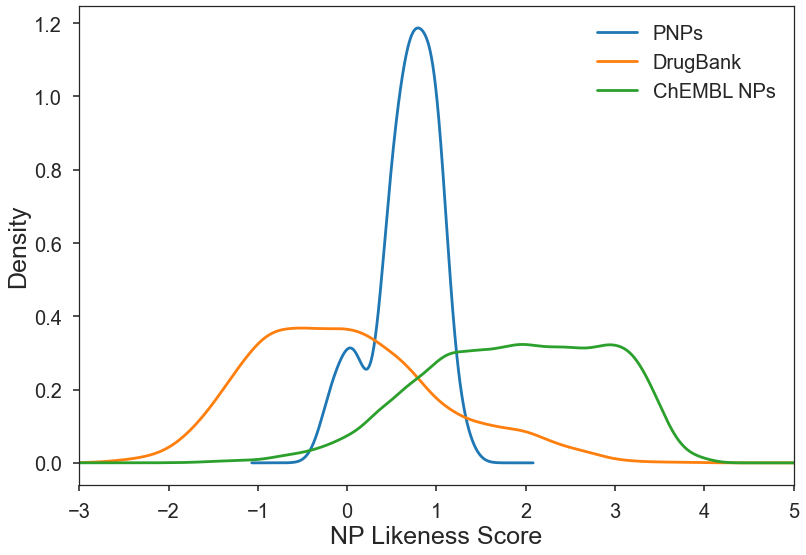

In [7]:
fig = plt.figure()
cpds["NP_Score"].plot.density(label="PNPs")
drugbank["NP_Score"].plot.density(label="DrugBank")
chembl_np["NP_Score"].plot.density(label="ChEMBL NPs")
# plt.title("Distribution of NP Likeness Scores")
plt.xlabel("NP Likeness Score")
plt.xlim((-3, 5))
plt.legend()
fig.savefig("plots/np_likeness_distribution.png", bbox_inches='tight');

#### QED

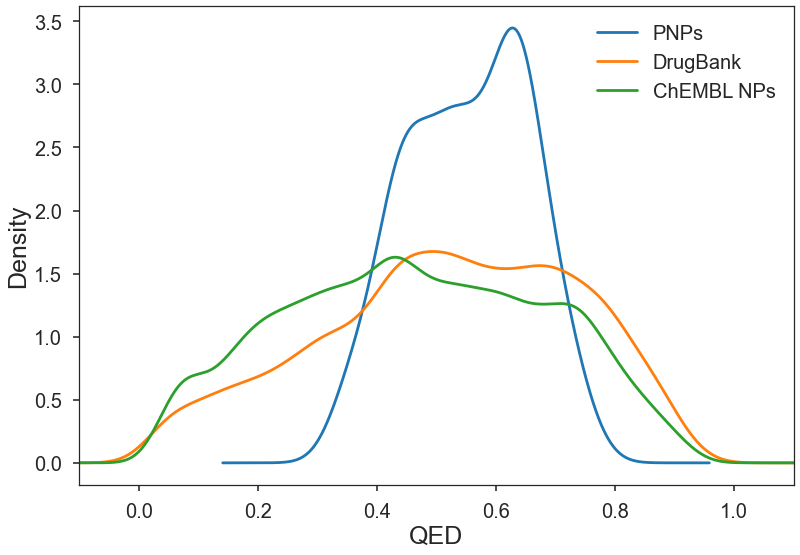

In [8]:
fig = plt.figure()
cpds["QED"].plot.density(label="PNPs")
drugbank["QED"].plot.density(label="DrugBank")
chembl_np["QED"].plot.density(label="ChEMBL NPs")
# plt.title("Distribution of NP Likeness Scores")
plt.xlabel("QED")
plt.xlim((-0.1, 1.1))
plt.legend()
fig.savefig("plots/qed_distribution.png", bbox_inches='tight');

### Box Plot

Shape                                             :      38295 /    2  [ NP_Score, Data Set ]  


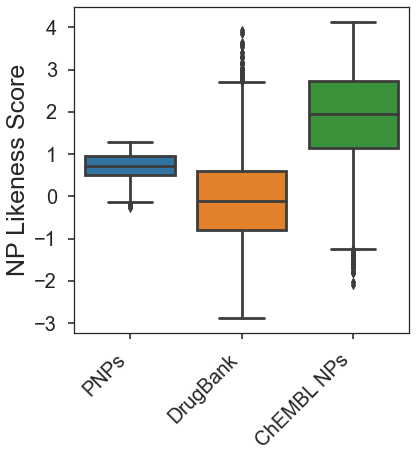

In [9]:
columns = ["NP_Score", "Data Set"]
tmp = pd.concat([cpds[columns], drugbank[columns], chembl_np[columns]])
lp(tmp)
fig, _ = plt.subplots(figsize=(6, 6))
box = sns.boxplot(x=tmp["Data Set"], y=tmp["NP_Score"])
box.set_title("")
box.set_ylabel("NP Likeness Score")
box.set_xlabel("")
box.set_xticklabels(box.get_xticklabels(), rotation=45, horizontalalignment='right');
# fig = hm.get_figure()
fig.savefig(f"plots/np_likeness_boxplot.png", bbox_inches='tight');

## NP-Scout Scores

The NP-Scout scores were obtained by submitting the respective data sets to the web service at this page: https://nerdd.zbh.uni-hamburg.de/npscout

### Load Data Sets

Only the entries for which a score could be calculated by NP Scout are used.

In [10]:
chembl_np = pd.read_csv("../tmp/chembl_np_std_np_scout.tsv", sep="\t")
lp(chembl_np, "ChEMBL NPs")
chembl_np = chembl_np[~chembl_np["NP class probability"].isnull()]
chembl_np["Data Set"] = "ChEMBL NPs"
lp(chembl_np, "ChEMBL NPs (non-Null)")

drugbank = pd.read_csv("../tmp/drugbank_std_np_scout.tsv", sep="\t")
lp(drugbank, "DrugBank")
drugbank = drugbank[~drugbank["NP class probability"].isnull()]
drugbank["Data Set"] = "DrugBank"
lp(drugbank, "DrugBank (non-Null)")

cpds = pd.read_csv("../tmp/internal_cpds_std_np_scout.tsv", sep="\t")
lp(cpds, "Internal compounds")
cpds = cpds[~cpds["NP class probability"].isnull()]
cpds["Data Set"] = "PNPs"
lp(cpds, "Internal compounds (non-Null)")

Shape ChEMBL NPs                                  :      30655 /    4  [ SMILES, Molecule Name, Error/Warning, NP class probability ]  ( NAN values in 2 col(s) )
Shape ChEMBL NPs (non-Null)                       :      30390 /    5  [ SMILES, Molecule Name, Error/Warning, NP class probability, Data Set ]  
Shape DrugBank                                    :       7472 /    4  [ SMILES, Molecule Name, Error/Warning, NP class probability ]  ( NAN values in 2 col(s) )
Shape DrugBank (non-Null)                         :       6912 /    5  [ SMILES, Molecule Name, Error/Warning, NP class probability, Data Set ]  
Shape Internal compounds                          :        168 /    4  [ SMILES, Molecule Name, Error/Warning, NP class probability ]  
Shape Internal compounds (non-Null)               :        168 /    5  [ SMILES, Molecule Name, Error/Warning, NP class probability, Data Set ]  


### Distribution Plots

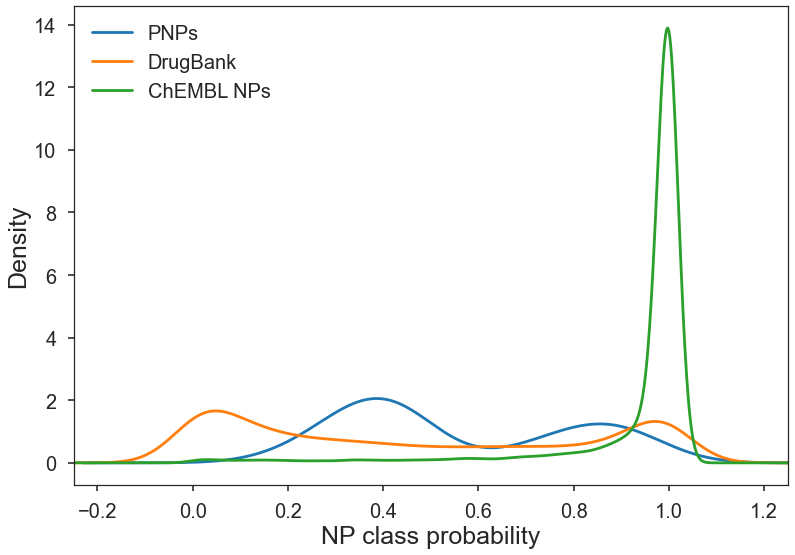

In [11]:
fig = plt.figure()
cpds["NP class probability"].plot.density(label="PNPs")
drugbank["NP class probability"].plot.density(label="DrugBank")
chembl_np["NP class probability"].plot.density(label="ChEMBL NPs")
# plt.title("Distribution of NP Likeness Scores")
plt.xlabel("NP class probability")
plt.xlim((-0.25, 1.25))
plt.legend()
fig.savefig("plots/np_class_prob.png", bbox_inches='tight');

### Box Plot

Shape                                             :      37470 /    2  [ NP class probability, Data Set ]  


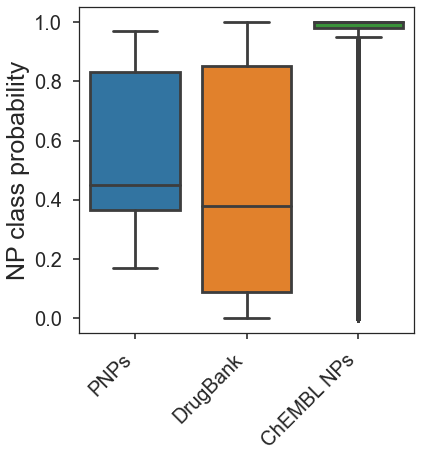

In [12]:
columns = ["NP class probability", "Data Set"]
tmp = pd.concat([cpds[columns], drugbank[columns], chembl_np[columns]])
lp(tmp)
fig, _ = plt.subplots(figsize=(6, 6))
box = sns.boxplot(x=tmp["Data Set"], y=tmp["NP class probability"])
box.set_title("")
# box.set_ylabel("NP Likeness Score")
box.set_xlabel("")
box.set_xticklabels(box.get_xticklabels(), rotation=45, horizontalalignment='right');
# fig = hm.get_figure()
fig.savefig(f"plots/np_class_prob_boxplot.png", bbox_inches='tight');

### Violin Plot

Shape                                             :      37470 /    2  [ NP class probability, Data Set ]  


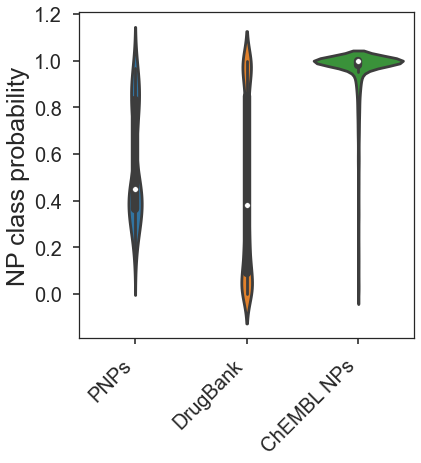

In [13]:
columns = ["NP class probability", "Data Set"]
tmp = pd.concat([cpds[columns], drugbank[columns], chembl_np[columns]])
lp(tmp)
fig, _ = plt.subplots(figsize=(6, 6))
box = sns.violinplot(x=tmp["Data Set"], y=tmp["NP class probability"])
box.set_title("")
# box.set_ylabel("NP Likeness Score")
box.set_xlabel("")
box.set_xticklabels(box.get_xticklabels(), rotation=45, horizontalalignment='right');
# fig = hm.get_figure()
fig.savefig(f"plots/np_class_prob_violinplot.png", bbox_inches='tight');